<a href="https://colab.research.google.com/github/varunkumark1997/EVA5-Assignment/blob/master/MNIST_model_level_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:

    Change the output channels in each layers
    Add Batch Normalization

Results:

    Parameters: 10,970
    Best Train Accuracy: 99.56
    Best Test Accuracy: 99.20

Analysis:

    We have reduced the number of parameters by decreasing the number of kernels as the dataset is simple, large number of kernels are overhead to the network.
    Batch normalization has added an extra effort in normalising the input image batches,
    before being processed by the kernels and intern helping the kernels to reach their optimum value.
    We can try adding the global average pooling to improve the accuracy of our model.

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
train_transforms = transforms.Compose(
                    [
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])
                    
test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test  = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
SEED = 1

cuda = torch.cuda.is_available()
print('is CUDA available', cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

trainloader = torch.utils.data.DataLoader(train, **dataloader_args)

testloader = torch.utils.data.DataLoader(test, **dataloader_args)

is CUDA available True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Train Data
- Numpy Shape (60000, 28, 28)
- Tensor Shape torch.Size([60000, 28, 28])
- min tensor(-0.4242)
- max tensor(2.8215)
- mean tensor(-0.0002)
- std tensor(1.0000)
- var tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


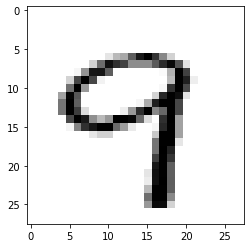

In [6]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('Train Data')
print('- Numpy Shape', train.train_data.cpu().numpy().shape)
print('- Tensor Shape', train.train_data.size())
print('- min', torch.min(train_data))
print('- max', torch.max(train_data))
print('- mean', torch.mean(train_data))
print('- std', torch.std(train_data))
print('- var', torch.var(train_data))

dataiterator = iter(trainloader)
images, labels = dataiterator.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

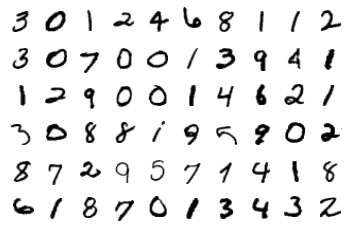

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),            
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10), 
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

In [16]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [17]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10):
    print('\nEPOCH:', epoch)
    train(model, device, trainloader, optimizer, epoch)
    test(model, device, testloader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.021293938159942627 batch_id=468 Accuracy=94.72: 100%|██████████| 469/469 [00:11<00:00, 40.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9828/10000 (98.28%)

EPOCH: 1


loss=0.08084186166524887 batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:11<00:00, 40.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


loss=0.018791725859045982 batch_id=468 Accuracy=98.785: 100%|██████████| 469/469 [00:11<00:00, 40.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9875/10000 (98.75%)

EPOCH: 3


loss=0.006399400532245636 batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9878/10000 (98.78%)

EPOCH: 4


loss=0.007564843166619539 batch_id=468 Accuracy=99.155: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9895/10000 (98.95%)

EPOCH: 5


loss=0.013713531196117401 batch_id=468 Accuracy=99.28166666666667: 100%|██████████| 469/469 [00:11<00:00, 40.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


loss=0.006438432261347771 batch_id=468 Accuracy=99.34333333333333: 100%|██████████| 469/469 [00:11<00:00, 40.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


loss=0.002824743278324604 batch_id=468 Accuracy=99.42166666666667: 100%|██████████| 469/469 [00:11<00:00, 40.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


loss=0.031057516112923622 batch_id=468 Accuracy=99.51166666666667: 100%|██████████| 469/469 [00:11<00:00, 42.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9882/10000 (98.82%)

EPOCH: 9


loss=0.009409578517079353 batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.99it/s]



Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Testing Accuracy')

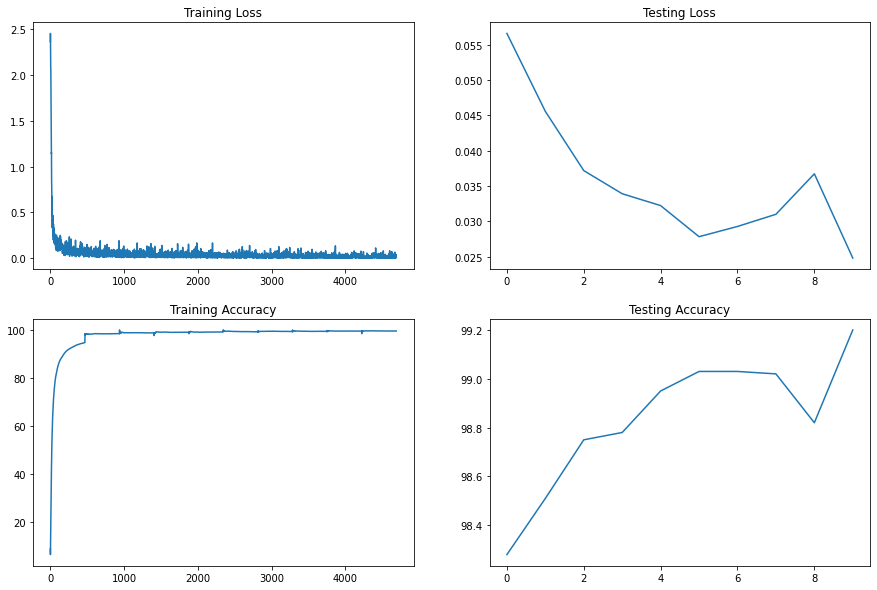

In [18]:
fig, axis = plt.subplots(2, 2, figsize=(15,10))
axis[0, 0].plot(train_losses)
axis[0, 0].set_title("Training Loss")
axis[1 ,0].plot(train_acc)
axis[1, 0].set_title("Training Accuracy")
axis[0 ,1].plot(test_losses)
axis[0, 1].set_title("Testing Loss")
axis[1 ,1].plot(test_acc)
axis[1, 1].set_title("Testing Accuracy")